<a href="https://colab.research.google.com/github/Pistolll/prak2_TOVII/blob/main/!2prakTOVII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Импортируем библиотеки для обработки данных, машинного обучения и нейросетей
import gym
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Загружаем датасет CIC-DDoS2019 с GitHub
url = "https://raw.githubusercontent.com/Pistolll/prak2_TOVII/refs/heads/main/cicddos2019_dataset.csv"
df = pd.read_csv(url)

# Выводим первые строки таблицы
print("Пример данных:")
print(df.head())

# Смотрим уникальные значения метки трафика
print("\nТипы трафика:", df['Label'].unique())


Пример данных:
   Unnamed: 0  Protocol  Flow Duration  Total Fwd Packets  \
0           0        17         216631                  6   
1           1        17              2                  2   
2           2        17             48                  2   
3           3        17         107319                  4   
4           4        17         107271                  4   

   Total Backward Packets  Fwd Packets Length Total  Bwd Packets Length Total  \
0                       0                    2088.0                       0.0   
1                       0                     802.0                       0.0   
2                       0                     766.0                       0.0   
3                       0                    1398.0                       0.0   
4                       0                    1438.0                       0.0   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  ...  \
0                  393.0                  321.0    

In [3]:
# Заменяем строковые метки: 'Benign' → 0, всё остальное (атаки) → 1
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Удаляем пропущенные значения
df = df.dropna()

# Оставляем только числовые столбцы
df = df.select_dtypes(include=[np.number])

# Масштабируем признаки с помощью стандартизации (z-score)
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Label', axis=1))  # признаки
y = df['Label'].values  # метки

In [4]:
# Разбиваем данные: 80% - обучение, 20% - тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Создаём среду обучения на основе интерфейса OpenAI Gym
class TrafficEnv(gym.Env):
    def __init__(self, X, y):
        super(TrafficEnv, self).__init__()
        self.X = X  # входные данные
        self.y = y  # метки
        self.index = 0  # текущий индекс
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)  # действия: 0 = benign, 1 = attack

    def reset(self):
        self.index = 0  # сброс индекса
        return self.X[self.index]

    def step(self, action):
        label = self.y[self.index]  # истинная метка
        reward = 1 if action == label else -1  # +1 за правильную классификацию, -1 за ошибку
        self.index += 1
        done = self.index >= len(self.X)  # проверка конца эпизода
        obs = self.X[self.index] if not done else np.zeros_like(self.X[0])  # следующее наблюдение
        return obs, reward, done, {}


In [6]:
# Простая fully-connected нейросеть для Q-Learning
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),  # первый слой
            nn.ReLU(),  # активация
            nn.Linear(128, output_dim)  # выходной слой
        )

    def forward(self, x):
        return self.net(x)


In [17]:
from tqdm import trange  # Импортируем прогресс-бар для отображения процесса обучения в цикле

def train_agent(env, episodes=30, gamma=0.99):
    """
    Обучает агента в среде с помощью DQN и одной переменной epsilon.

    Параметры:
    - env: среда обучения (совместимая с OpenAI Gym)
    - episodes: количество эпизодов для обучения агента
    - gamma: коэффициент дисконтирования наград (будущих шагов)

    Возвращает:
    - обученную модель DQN
    - список суммарных наград за каждый эпизод обучения
    """
    # Создаем модель DQN с размерностью входа = размер состояния, выход = количество действий
    model = DQN(env.observation_space.shape[0], env.action_space.n)
    # Оптимизатор Adam с параметрами по умолчанию для обновления весов модели
    optimizer = optim.Adam(model.parameters())
    # Функция потерь — среднеквадратичная ошибка между Q-значениями
    loss_fn = nn.MSELoss()

    replay_memory = []  # Память для хранения переходов (опытов) агента
    batch_size = 64     # Размер выборки из памяти для обучения за один шаг
    epsilon = 1.0       # Параметр для epsilon-greedy стратегии (начинаем с максимального исследования)
    rewards_all = []    # Список для хранения суммарных наград за каждый эпизод

    # Цикл по эпизодам с прогресс-баром
    for episode in trange(episodes, desc="Обучение агента"):
        obs = env.reset()       # Сбрасываем среду в начальное состояние
        total_reward = 0        # Накопленная награда за эпизод
        done = False            # Флаг завершения эпизода
        step_count = 0          # Счётчик шагов в эпизоде

        # Цикл шагов в эпизоде — пока эпизод не завершён или не достигнут лимит шагов (100)
        while not done and step_count < 100:
            # Выбор действия по epsilon-greedy: с вероятностью epsilon случайное действие,
            # иначе действие с максимальным Q-значением
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Случайное действие (исследование)
            else:
                with torch.no_grad():  # Вычисления без сохранения градиентов (для скорости)
                    state_tensor = torch.FloatTensor(obs).unsqueeze(0)  # Преобразуем состояние в тензор с размером (1, state_dim)
                    q_vals = model(state_tensor)  # Предсказание Q-значений для всех действий
                    action = q_vals.argmax().item()  # Выбираем действие с максимальным Q-значением

            # Выполняем действие в среде и получаем новое состояние, награду и признак завершения эпизода
            next_obs, reward, done, _ = env.step(action)
            total_reward += reward  # Накопляем награду
            step_count += 1        # Увеличиваем счётчик шагов

            # Добавляем переход (опыт) в replay memory
            replay_memory.append((obs, action, reward, next_obs, done))
            obs = next_obs  # Обновляем текущее состояние

            # Если накоплено достаточно опыта для обучения
            if len(replay_memory) >= batch_size:
                # Выбираем случайный батч из памяти для обучения
                batch = random.sample(replay_memory, batch_size)
                states, actions, rewards_b, next_states, dones = zip(*batch)

                # Преобразуем батчи в тензоры для подачи в модель
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)  # Для gather нужен 2D-тензор
                rewards_b = torch.FloatTensor(rewards_b).unsqueeze(1)
                next_states = torch.FloatTensor(next_states)
                dones = torch.BoolTensor(dones).unsqueeze(1)

                # Получаем Q-значения для выбранных действий из модели
                q_values = model(states).gather(1, actions)
                # Вычисляем максимальные Q-значения для следующих состояний (без учета действий)
                next_q_values = model(next_states).max(1)[0].unsqueeze(1)
                # Вычисляем целевые значения с учетом дисконтирования и признака завершения эпизода
                expected_q = rewards_b + gamma * next_q_values * (~dones)

                # Вычисляем ошибку между предсказанными и целевыми Q-значениями
                loss = loss_fn(q_values, expected_q.detach())

                # Обновляем веса модели с помощью обратного распространения ошибки
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Плавное уменьшение epsilon — уменьшаем исследование со временем, но не ниже 0.1
        epsilon = max(0.1, epsilon * 0.995)
        rewards_all.append(total_reward)  # Записываем награду за эпизод

        # Выводим промежуточную информацию по текущему эпизоду
        print(f"Эпизод {episode+1}: Общая награда = {total_reward}, шагов: {step_count}, ε = {epsilon:.3f}")

    # Возвращаем обученную модель и список наград
    return model, rewards_all

# Создаем среду для обучения (пример: среда управления трафиком)
env = TrafficEnv(X_train, y_train)
# Запускаем процесс обучения агента на 30 эпизодов
model, rewards = train_agent(env, episodes=30)


Обучение агента:   3%|▎         | 1/30 [00:00<00:07,  3.75it/s]

Эпизод 1: Общая награда = -8, шагов: 100, ε = 0.995


Обучение агента:   7%|▋         | 2/30 [00:01<00:16,  1.67it/s]

Эпизод 2: Общая награда = -2, шагов: 100, ε = 0.990


Обучение агента:  10%|█         | 3/30 [00:01<00:15,  1.73it/s]

Эпизод 3: Общая награда = -2, шагов: 100, ε = 0.985


Обучение агента:  13%|█▎        | 4/30 [00:02<00:12,  2.03it/s]

Эпизод 4: Общая награда = 14, шагов: 100, ε = 0.980


Обучение агента:  17%|█▋        | 5/30 [00:02<00:11,  2.24it/s]

Эпизод 5: Общая награда = 28, шагов: 100, ε = 0.975


Обучение агента:  20%|██        | 6/30 [00:02<00:10,  2.39it/s]

Эпизод 6: Общая награда = -4, шагов: 100, ε = 0.970


Обучение агента:  23%|██▎       | 7/30 [00:03<00:09,  2.49it/s]

Эпизод 7: Общая награда = 4, шагов: 100, ε = 0.966


Обучение агента:  27%|██▋       | 8/30 [00:03<00:08,  2.59it/s]

Эпизод 8: Общая награда = 10, шагов: 100, ε = 0.961


Обучение агента:  30%|███       | 9/30 [00:03<00:07,  2.63it/s]

Эпизод 9: Общая награда = 10, шагов: 100, ε = 0.956


Обучение агента:  33%|███▎      | 10/30 [00:04<00:07,  2.69it/s]

Эпизод 10: Общая награда = 20, шагов: 100, ε = 0.951


Обучение агента:  37%|███▋      | 11/30 [00:04<00:07,  2.70it/s]

Эпизод 11: Общая награда = 14, шагов: 100, ε = 0.946


Обучение агента:  40%|████      | 12/30 [00:04<00:06,  2.62it/s]

Эпизод 12: Общая награда = 12, шагов: 100, ε = 0.942


Обучение агента:  43%|████▎     | 13/30 [00:05<00:06,  2.66it/s]

Эпизод 13: Общая награда = -6, шагов: 100, ε = 0.937


Обучение агента:  47%|████▋     | 14/30 [00:05<00:06,  2.66it/s]

Эпизод 14: Общая награда = -2, шагов: 100, ε = 0.932


Обучение агента:  50%|█████     | 15/30 [00:06<00:05,  2.63it/s]

Эпизод 15: Общая награда = 20, шагов: 100, ε = 0.928


Обучение агента:  53%|█████▎    | 16/30 [00:06<00:05,  2.58it/s]

Эпизод 16: Общая награда = 10, шагов: 100, ε = 0.923


Обучение агента:  57%|█████▋    | 17/30 [00:07<00:05,  2.21it/s]

Эпизод 17: Общая награда = 2, шагов: 100, ε = 0.918


Обучение агента:  60%|██████    | 18/30 [00:07<00:06,  1.98it/s]

Эпизод 18: Общая награда = -6, шагов: 100, ε = 0.914


Обучение агента:  63%|██████▎   | 19/30 [00:08<00:05,  1.85it/s]

Эпизод 19: Общая награда = 12, шагов: 100, ε = 0.909


Обучение агента:  67%|██████▋   | 20/30 [00:08<00:05,  1.78it/s]

Эпизод 20: Общая награда = 0, шагов: 100, ε = 0.905


Обучение агента:  70%|███████   | 21/30 [00:09<00:04,  1.93it/s]

Эпизод 21: Общая награда = -2, шагов: 100, ε = 0.900


Обучение агента:  73%|███████▎  | 22/30 [00:09<00:03,  2.11it/s]

Эпизод 22: Общая награда = -2, шагов: 100, ε = 0.896


Обучение агента:  77%|███████▋  | 23/30 [00:10<00:03,  2.23it/s]

Эпизод 23: Общая награда = 10, шагов: 100, ε = 0.891


Обучение агента:  80%|████████  | 24/30 [00:10<00:02,  2.36it/s]

Эпизод 24: Общая награда = 2, шагов: 100, ε = 0.887


Обучение агента:  83%|████████▎ | 25/30 [00:10<00:02,  2.49it/s]

Эпизод 25: Общая награда = 22, шагов: 100, ε = 0.882


Обучение агента:  87%|████████▋ | 26/30 [00:11<00:01,  2.55it/s]

Эпизод 26: Общая награда = 12, шагов: 100, ε = 0.878


Обучение агента:  90%|█████████ | 27/30 [00:11<00:01,  2.62it/s]

Эпизод 27: Общая награда = -6, шагов: 100, ε = 0.873


Обучение агента:  93%|█████████▎| 28/30 [00:11<00:00,  2.67it/s]

Эпизод 28: Общая награда = 16, шагов: 100, ε = 0.869


Обучение агента:  97%|█████████▋| 29/30 [00:12<00:00,  2.65it/s]

Эпизод 29: Общая награда = -6, шагов: 100, ε = 0.865


Обучение агента: 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]

Эпизод 30: Общая награда = 16, шагов: 100, ε = 0.860


 Награды — это числовые значения, которые агент получает в ходе обучения в каждом эпизоде. Они отражают, насколько хорошо агент справился с задачей на каждом этапе взаимодействия со средой.

Ось X (горизонтальная) — номер эпизода обучения.
Ось Y (вертикальная) — суммарная награда, полученная агентом за один эпизод.
Кривая — показывает, как менялась общая награда по мере обучения агента.


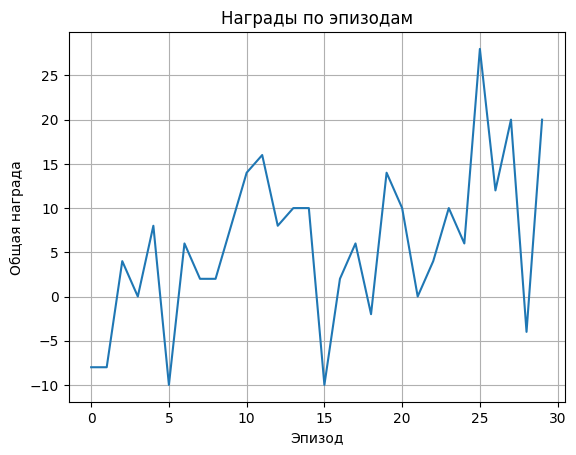

In [14]:
# Строим график наград по эпизодам
plt.plot(rewards)
plt.title("Награды по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Общая награда")
plt.grid(True)
plt.show()

🔹 Что такое ε в контексте обучения с подкреплением?
Эпсилон используется в epsilon-greedy strategy — одном из ключевых методов выбора действий агентом в процессе обучения.

🔸 Зачем он нужен?
Эпсилон нужен для баланса между исследованием и эксплуатацией:

Исследование: агент пробует новые действия, которые могут привести к лучшим наградам в будущем.

Эксплуатация: агент выбирает известное наилучшее действие на основе уже полученного опыта (Q-значений).

🔸 Как работает ε-жадная стратегия:
На каждом шаге агент:

с вероятностью ε выбирает случайное действие (исследует),

с вероятностью 1 - ε выбирает лучшее по Q-сети действие (эксплуатирует).

🔸 Почему важна постепенная затухающая ε-стратегия?
В начале обучения — ε высокий (например, 1.0), агент изучает мир, пробует всё подряд.

Постепенно — ε уменьшается (например, до 0.05), агент всё чаще действует на основе уже выученной Q-сети.

Это позволяет сначала собрать разнообразный опыт, а потом эффективно использовать знания для максимизации награды.

Что такое награда в Reinforcement Learning
В обучении с подкреплением:

Агент принимает решения (в нашем случае — классифицирует сетевой трафик как Benign или Attack);

За каждое действие он получает награду:
+1, если правильно классифицировал (например, верно определил атаку);
−1, если ошибся (например, пропустил вредоносный запрос).

Суммарная награда за эпизод — это общее количество очков, набранных агентом при прохождении всей выборки.

In [15]:
# Оцениваем точность классификации RL-модели
def evaluate_model(model, X, y):
    X = torch.FloatTensor(X)  # преобразуем в тензоры
    preds = model(X).argmax(dim=1).numpy()  # получаем предсказания
    from sklearn.metrics import classification_report
    print(classification_report(y, preds, target_names=["Benign", "Attack"]))  # метрики

evaluate_model(model, X_test, y_test)


              precision    recall  f1-score   support

      Benign       0.81      0.78      0.79      1433
      Attack       0.96      0.97      0.96      8281

    accuracy                           0.94      9714
   macro avg       0.88      0.87      0.88      9714
weighted avg       0.94      0.94      0.94      9714



Объяснение метрик:

Precision	Точность — сколько предсказанных Attack действительно были атаками

Recall	Полнота — сколько всех реальных Attack было правильно найдено

F1-score	Среднее между precision и recall

Support	Сколько всего примеров каждого класса в тесте

In [16]:
# Обучаем классическую модель Random Forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

# Выводим метрики качества
print("\n Сравнение с RandomForest:")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_rf, target_names=["Benign", "Attack"]))



 Сравнение с RandomForest:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1433
      Attack       1.00      1.00      1.00      8281

    accuracy                           1.00      9714
   macro avg       1.00      1.00      1.00      9714
weighted avg       1.00      1.00      1.00      9714

